### Import required libraries for data acquisition

In [21]:
import pickle
from os import listdir, getcwd
from os.path import dirname, abspath, join
import cv2
import numpy as np

Global variabels

In [ ]:
seq_length = 10
is_sequential = True

Load Data from `.pickle` files

In [54]:
data = {}
data_dir = abspath(dirname(getcwd()))
for f in listdir(data_dir):
    if '.pickle' in f:
        data_path = join(data_dir, f)
        with open(data_path, 'rb') as fp:
            data[data_path.split('/')[-1].split('.')[0]] = pickle.load(fp)

Convert list data to numpy array (`np.ndarray`)

In [55]:


def data_to_numpy(data: list) -> np.array:
    arr = np.empty((len(data),len(data[0]), len(data[0][0])), np.float64)
    for i in range(len(data)):
        for j in range(len(data[0])):
            arr[i, j, :] = [data[i][j]['x'], data[i][j]['y'], data[i][j]['z']]
    return arr

In [83]:
def generate_data(data, type_='all', is_sequential=False):

    final_data = []
    if type_ == 'l':
        arr_l = np.concatenate((data_to_numpy(data['l_s']), data_to_numpy(data['l_ns'])), axis=0)
        arr_nl = np.concatenate((data_to_numpy(data['nl_s']), data_to_numpy(data['nl_ns'])), axis=0)
        if is_sequential:
            arr_l = to_sequential(arr_l)
            arr_nl = to_sequential(arr_nl)
        y = np.concatenate((np.zeros(arr_l.shape[0]), np.ones(arr_nl.shape[0])), axis=0)

        final_data = [np.concatenate((arr_l, arr_nl), axis=0), y, ['looking', 'not_looking']]
    
    elif type_ == 's':
        arr_s = np.concatenate((data_to_numpy(data['l_s']), data_to_numpy(data['nl_s'])), axis=0)
        arr_ns = np.concatenate((data_to_numpy(data['l_ns']), data_to_numpy(data['nl_ns'])), axis=0)
        if is_sequential:
            arr_s = to_sequential(arr_s)
            arr_ns = to_sequential(arr_ns)
        y = np.concatenate((np.zeros(arr_s.shape[0]), np.ones(arr_ns.shape[0])), axis=0)
        
        final_data = [np.concatenate((arr_s, arr_ns), axis=0), y, ['speaking', 'not_speaking']]
    
    elif type_ == 'all':
        l_s = data_to_numpy(data['l_s'])
        nl_s = data_to_numpy(data['nl_s'])
        l_ns = data_to_numpy(data['l_ns'])
        nl_ns = data_to_numpy(data['nl_ns'])
        if is_sequential:
            l_s = to_sequential(l_s)
            nl_s = to_sequential(nl_s)
            l_ns = to_sequential(l_ns)
            nl_ns = to_sequential(nl_ns)
        X = np.concatenate((l_s, nl_s, l_ns, nl_ns), axis=0)
        y = np.concatenate((np.zeros(l_s.shape[0]), np.ones(nl_s.shape[0]), np.ones(l_ns.shape[0])*2, np.ones(nl_ns.shape[0])*3), axis=0)

        final_data = [X, y, ['looking_speaking', 'not_looking_speaking', 'looking_not_speaking', 'not_looking_not_speaking']]
    
    return final_data

In [69]:
def standardize_data(data, axis_, center=True, scale=True):
    shape_ = list(data.shape)
    shape_[axis_] = 1
        
    if center:
        data = data - data.mean(axis=axis_).reshape(*shape_)
    if scale:
        data = data - data.min(axis=axis_).reshape(*shape_)
        data = data / (data.max(axis=axis_) - data.min(axis=axis_)).reshape(*shape_)

    return data

def to_sequential(data: np.ndarray, seq_length: int=10, axis: int=1) -> np.ndarray:
    '''Transforms to sequential data

    Parameters
    ----------
    data: np.ndarray
        The data to be processed
    seq_length: int
        The total number of consequent samples that would be used
        to generate the sequential data
    axis: int
        The nex axis where the sequences would be put in

    Returns
    -------
        np.ndarray
        The transformed sequential data

    '''

    shape_ = tuple(val - seq_length + 1 if i == 0 else val for i, val in enumerate(data.shape))
    shape_ = shape_[:axis] + (seq_length,) + shape_[axis:]
    seq_data = np.zeros(shape_)
    for i in range(data.shape[0]-seq_length+1):
        seq_data[i, :, :, :] = data[i:i+seq_length, :, :]
    return seq_data


In [141]:
X, y, label_text = generate_data(data, type_='s', is_sequential=is_sequential)

In [27]:
from sklearn.model_selection import train_test_split
X = X.reshape(X.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn import svm
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(hidden_layer_sizes=400, verbose=True, random_state=1, max_iter=50, tol=0.001).fit(X_train, y_train)

from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()
# clf = KNeighborsClassifier(n_neighbors=3)
# clf = RadiusNeighborsClassifier(radius=0.1)
# clf = KDTree(X, leaf_size=2)
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9675324675324676

In [28]:
X.shape

(6930, 7170)

In [142]:
from sklearn.decomposition import PCA

X_dec = np.copy(X.reshape(X.shape[0], -1))
pca = PCA(n_components=150)
X_dec = pca.fit_transform(X_dec)

# print(pca.explained_variance_ratio_)

# print(pca.singular_values_)

In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dec, y, test_size=0.5, random_state=42)

from sklearn import svm
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(hidden_layer_sizes=400, verbose=True, random_state=1, max_iter=50, tol=0.001).fit(X_train, y_train)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# clf = AdaBoostClassifier(n_estimators=150, random_state=0)
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#     max_depth=1, random_state=0)
# clf = GaussianNB()
clf = KNeighborsClassifier(n_neighbors=3)
# clf = RadiusNeighborsClassifier(radius=0.1)
# clf = KDTree(X, leaf_size=2)
# clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.885935085007728

In [101]:
label_text

['speaking', 'not_speaking']

In [125]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1551,   88],
       [  98, 1498]])

In [92]:
import mediapipe as mp
from protobuf_to_dict import protobuf_to_dict

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [190]:
import cv2
import numpy as np

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name

sp_cls = np.zeros(15)
max_num_faces=1
refine_landmarks=True
min_detection_confidence=0.5
min_tracking_confidence=0.5
with mp_face_mesh.FaceMesh(
        max_num_faces=max_num_faces,
        refine_landmarks=refine_landmarks,
        min_detection_confidence=min_detection_confidence,
        min_tracking_confidence=min_tracking_confidence,
    ) as face_mesh:
    cap = cv2.VideoCapture('vid1.mp4')

    # Check if camera opened successfully
    if (cap.isOpened()== False):
      print("Error opening video stream or file")

    # Read until video is completed
    count = 0
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        # image.flags.writeable = False
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)
        # print(results)
        # break

        # Draw the face mesh annotations on the image.
        # image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # add facelandmarks to the keypoints listimage
                keypoint = protobuf_to_dict(face_landmarks)["landmark"]
        # print(len(keypoint))
        # break
        s = np.array([[i['x'], i['y'], i['z']] for i in keypoint])
        s = np.expand_dims(s, axis=0)
        s = standardize_data(s, axis_=1)
        if is_sequential:
          if count is 0:
            seq_frames = s
            count += 1
            continue
          elif count < seq_length - 1:
            seq_frames = np.concatenate((seq_frames, s), axis=0)
            count += 1
            continue
          elif count == seq_length - 1:
            seq_frames = np.concatenate((seq_frames, s), axis=0)
            inference_frame = seq_frames.reshape(1, -1)
            # print(inference_frame.shape)
            # break
            inference_frame = pca.transform(inference_frame)
            count += 1
          else:
            seq_frames = np.roll(seq_frames, 1, axis=0)
            seq_frames[0] = s
            inference_frame = seq_frames.reshape(1, -1)
            # print(inference_frame.shape)
            inference_frame = pca.transform(inference_frame)
        else:
          inference_frame = s.reshape(1, -1)
          inference_frame = pca.transform(inference_frame)
        # print(s.shape)
        
        y_pred = clf.predict(inference_frame)
        # print(label_text[int(y_pred)])
        # print(f'diff: {s[]}')
        sp_cls = np.roll(sp_cls, 1, axis=0)
        sp_cls[0] = 1 if np.sum(np.abs(s[0, 13] - s[0, 14])) > 0.02 else 0
        txt = 'speaking' if np.sum(sp_cls)/2 >= 0.5 else 'not speaking'
        window_name = 'Image'
  
        # font
        font = cv2.FONT_HERSHEY_SIMPLEX
        # org
        org = (50, 50)
          
        # fontScale
        fontScale = 1
          
        # Blue color in BGR
        color = (255, 0, 0)
          
        # Line thickness of 2 px
        thickness = 2
          
        # Using cv2.putText() method
        # image = cv2.putText(image, label_text[int(y_pred)], org, font, fontScale, color, thickness, cv2.LINE_AA)
        image = cv2.putText(image, txt, org, font, fontScale, color, thickness, cv2.LINE_AA)
        # print(label_text[int(y_pred)])
        # break
        # Display the resulting frame
        cv2.imshow('Frame',image)

        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break

      # Break the loop
      else: 
        break

    # When everything done, release the video capture object
    cap.release()

# Closes all the frames
cv2.destroyAllWindows()

SyntaxError: invalid syntax (1548063246.py, line 81)

In [179]:
var = np.var(X, axis=0)
var[:, 0].shape

(478,)

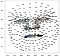

In [178]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(7, 7), dpi=10)
# g.shape
f = g[100, :, 0:2]
# f.shape
# f = arr_s[750, :, 0:2]
# fig, axs = plt.subplots(nrows=1, ncols=1)
plt.scatter(f[:, 0], f[:, 1], s=1, c=np.arange(478), cmap='jet')
for i in range(478):
    plt.annotate(str(i), (f[i, 0], f[i, 1]))
# plt.subplots_adjust(wspace = .5)
# for i in range(3):
#     pcm = axs[i].scatter(f[:, 0], f[:, 1], s=5, c=var[:, i], cmap='jet')
#     axs[i].invert_yaxis()
#     fig.colorbar(pcm, ax=axs[i], orientation='horizontal')
plt.gca().invert_yaxis()
plt.show()

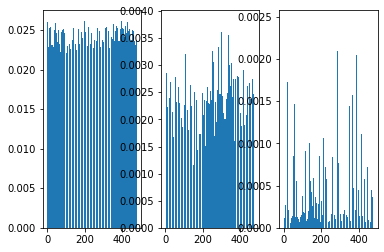

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    axs[i].bar(np.arange(var.shape[0]), var[:, i])
plt.show()

<Figure size 1600x200 with 0 Axes>

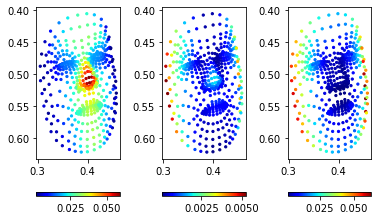

In [ ]:
from matplotlib.pyplot import figure



figure(figsize=(80, 10), dpi=20)
f = arr_s[750, :, 0:2]
fig, axs = plt.subplots(nrows=1, ncols=3)
plt.subplots_adjust(wspace = .5)
for i in range(3):
    pcm = axs[i].scatter(f[:, 0], f[:, 1], s=5, c=var[:, i], cmap='jet')
    axs[i].invert_yaxis()
    fig.colorbar(pcm, ax=axs[i], orientation='horizontal')
plt.show()


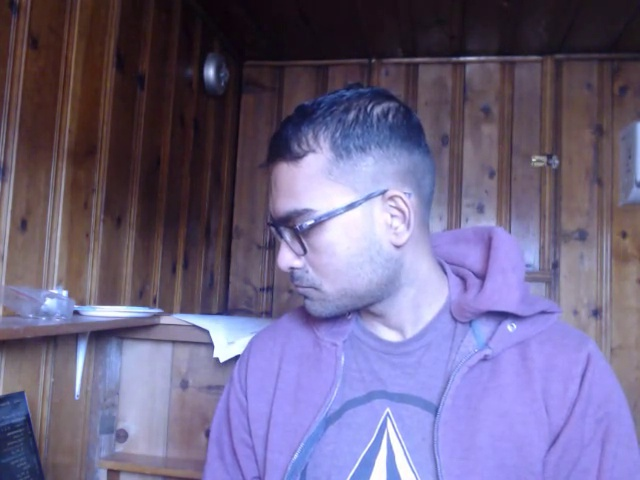

error: OpenCV(4.5.5) /io/opencv/modules/imgcodecs/src/loadsave.cpp:976: error: (-215:Assertion failed) !image.empty() in function 'imencode'


In [ ]:
import cv2
from IPython.display import display, Image

video = cv2.VideoCapture('lnlsns.mp4')
display_handle=display(None, display_id=True)
try:
    while video.isOpened():
        _, frame = video.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)